# Github NLP Project

#### For this project, we scrape data from GitHub repository README files. Our goal is  to build a model that can predict what programming language a repository is, given the text of the README file.

#### Our repositories come from a Github search for "advent of code". Advent of code is an annual coding challenge completed by many people in a variety of languages. 

In [1]:
from os import path
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

# Acquire

# Prepare

## Functions

In [2]:
def normalize(string):
    # lower case the string
    string = string.lower()

    # replace new lines with an empty space
    string = re.sub(r'\n',' ',string)
    
    # normalize unicode characters
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # replace . with space
    string = re.sub(r'\.',' ',string)
    
    # replace / with space
    string = re.sub(r'/',' ',string)
    
    # replace c++ th c plus plus
    string = re.sub(r'c\+\+','cplusplus',string)

    # replace c+ with c plus
    string = re.sub(r'c\+','cplus ',string)

    # replace c# with c sharp
    string = re.sub(r'c#','csharp ',string)

    # replace f# with f sharp
    string = re.sub(r'f#','fsharp ',string)
    
    # replaces certain special characters with a space
    string = re.sub(r'[\[\](){}]',' ', string)
    
    # replace multiple adjacent spaces with only one space
    string = re.sub(r'\s+',' ',string)

    # remove remaining special characters and numbers with regex
    string = re.sub(r'[^a-z\s]','', string)
    
    return string

In [3]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

In [4]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

In [5]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

In [6]:
def remove_stopwords(tokenized_string, extra_words=['advent', 'of','code', 'aoc', 'day', 'solution', 'httpsgithub','githubhttpsimg','hpphttpsgithub','httpsadventofcode', 'adventofcode','commstksgadventofcodeblobmasterreflections', 'httpadventofcode','com', 'github', 'http', 'https','adventofcodehttps','master','blob','username', 'reponame','svg','src'], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

### Read in json file containing repos and content

In [7]:
# read in content as json and save as dataframe
df = pd.read_json('datafiles/outdata.json')

In [8]:
# preview data
df.shape

(302, 6)

In [9]:
df.head()

,language,language_all,repo_full,author,repo,readme
0,Python,{'Python': 41534},0x8b/advent-of-code-2019,0x8b,advent-of-code-2019,# username's [advent of code 2019](https://adv...
1,Haskell,"{'Haskell': 42115, 'Python': 503}",1Computer1/advent,1Computer1,advent,# reponame of code solutions\n\ni'm probably n...
10,TypeScript,"{'TypeScript': 178903, 'Rust': 68139, 'Smarty'...",AlexAegis/advent-of-code,AlexAegis,advent-of-code,# [advent of code](https://adventofcode.com/)\...
100,Python,"{'Python': 64874, 'Julia': 27162}",ferrolho/advent-of-code,ferrolho,advent-of-code,# advent of code\n\n:santa: :christmas_tree: :...
101,Swift,{'Swift': 69603},fguchelaar/AdventOfCode2019,fguchelaar,AdventOfCode2019,# advent of code 2019\n\nmy solutions for the ...


### Create new columns which show readme content normalized, stemmed, and lemmatized

In [10]:
df = df.assign(normalized = df.readme.apply(normalize))
df = df.assign(stemmed = df.normalized.apply(stem))
df = df.assign(lemmatized = df.normalized.apply(lemmatize))

In [11]:
# preview results to decide which technique to use when reducing form of words (lemmatize vs stem)
df[['stemmed','lemmatized']].head()

,stemmed,lemmatized
0,usernam advent of code http adventofcod com so...,usernames advent of code http adventofcode com...
1,reponam of code solut im probabl not gonna do ...,reponame of code solution im probably not gonn...
10,advent of code http adventofcod com build stat...,advent of code http adventofcode com build sta...
100,advent of code santa christmastre gift my solu...,advent of code santa christmastree gift my sol...
101,advent of code my solut for the fifth instal o...,advent of code my solution for the fifth insta...


In [12]:
# People are not very creative with their repo names. 
df.repo.value_counts()

advent-of-code                  35
advent-of-code-2019             23
AdventOfCode                    16
adventofcode                    16
AdventOfCode2019                11
advent-of-code-2018             11
AdventOfCode2018                 8
aoc-2019                         7
adventofcode2019                 6
aoc2019                          5
AdventOfCode2015                 4
advent2019                       4
AdventOfCode2017                 4
aoc2017                          4
adventOfCode                     3
advent_of_code_2019              3
aoc                              3
Advent-of-Code-2019              3
advent-of-code-2015              3
advent-of-code-2017              3
advent-2019                      3
aoc19                            3
AdventOfCode-2019                2
advent_of_code_2018              2
Advent-of-Code                   2
AdventOfCode-2017                2
advent_of_code                   2
Advent-of-Code-2017              2
advent              

#### Lemmatization > Stemming

We choose to lemmatize instead of stemming for a couple of reasons. One, lemmatizing preserves the root word in the form of a real word. Our readme data is full of shortened and combined "words" that are not real words. A lot of this is noise. We do not want to stem the data because the words will look too similar to this noise. Secondly, stemming's advantage over lemmatization is its low computing requirements and quick results. Our data set is fairly small and such minor improvements are not important to us. In this case, it is better to lemmatize.

In [13]:
# Choose lemmatize and proceed forward with tokenization and stop words
# create new column called prepped which takes the lemmatized column and passes it through the tokenize function and remove_stopwords function
df = df.assign(prepped = df.lemmatized.apply(tokenize).apply(remove_stopwords))

In [14]:
df.prepped.head()

0      usernames daynamesolution tyranny rocket equat...
1      im probably gonna problem im gonna pretend lik...
10     build status travisci svgbranchmaster travisci...
100    santa christmastree gift problem might write s...
101    fifth installment creating package ive prepare...
Name: prepped, dtype: object

In [15]:
# 26 blank readme's as a result of removing stop words. We need to drop them.
df.prepped.value_counts().head()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              26
python                                                                                                                                                                                                                                                                                                                                                 

In [16]:
mask = df.prepped != ''
df = df[mask]
df.prepped.value_counts()

contribute inspired others bidra med dina losningar pa problemen vilket sprak du vill valj ett du kan eller ett du vill lara dig vi har ocksa en ledarbrada leaderboard pa koden till ledarbradan ar eed vi har ocksa en slackkanal dit alla ar valkomna att snacka eller egentligen allt mellan himmel och jord med lite koppling till kod maila infousername se eller twittra din epost till sa slapper vi er dina losningar far garna checkas en mapp med namn pa formen anvandarnamnsprak sa blir det lite lattare alla att fa overblick losningarna kan komma att diskuteras avsnitt av sa lagg med en readme md med en notis om du inte vill riskera att bli omnamnd                                                                                                                                                                                                                                                                                                                                                              

# Explore

In [17]:
# isolate language and prepped columns by dropping other columns
df = df.drop(columns={'author','language_all','readme','repo','normalized', 'stemmed', 'lemmatized','repo_full'})

In [18]:
df.head()

,language,prepped
0,Python,usernames daynamesolution tyranny rocket equat...
1,Haskell,im probably gonna problem im gonna pretend lik...
10,TypeScript,build status travisci svgbranchmaster travisci...
100,Python,santa christmastree gift problem might write s...
101,Swift,fifth installment creating package ive prepare...


### How many repos of each language exist?

In [19]:
df.language.value_counts(normalize=False)

Python              39
JavaScript          35
Haskell             25
Rust                19
Clojure             15
Go                  14
Java                12
Kotlin              12
Ruby                10
C#                  10
Elixir               9
C++                  8
Scala                8
R                    7
OCaml                5
TypeScript           4
PHP                  3
Jupyter Notebook     3
C                    3
HTML                 2
Elm                  2
Perl                 2
F#                   2
Scheme               2
Pony                 2
Crystal              2
Swift                2
Julia                2
Dart                 1
APL                  1
Shell                1
Coq                  1
Mathematica          1
Reason               1
PureScript           1
Erlang               1
TSQL                 1
Racket               1
Nim                  1
Ada                  1
Haxe                 1
PowerShell           1
Smalltalk            1
Eiffel     

### What percentage is this?

In [20]:
df.language.value_counts(normalize=True)

Python              0.141304
JavaScript          0.126812
Haskell             0.090580
Rust                0.068841
Clojure             0.054348
Go                  0.050725
Java                0.043478
Kotlin              0.043478
Ruby                0.036232
C#                  0.036232
Elixir              0.032609
C++                 0.028986
Scala               0.028986
R                   0.025362
OCaml               0.018116
TypeScript          0.014493
PHP                 0.010870
Jupyter Notebook    0.010870
C                   0.010870
HTML                0.007246
Elm                 0.007246
Perl                0.007246
F#                  0.007246
Scheme              0.007246
Pony                0.007246
Crystal             0.007246
Swift               0.007246
Julia               0.007246
Dart                0.003623
APL                 0.003623
Shell               0.003623
Coq                 0.003623
Mathematica         0.003623
Reason              0.003623
PureScript    

### What are the most common words in READMEs?

In [21]:
# get all text as a string
all_text = " ".join(df.prepped)
# convert to a list of words
all_words = all_text.split()

In [22]:
raw_count = pd.Series(all_words).value_counts()
# top 30 words
raw_count.head(30)

main              380
run               375
scala             327
input             315
part              292
hpp               288
problem           276
py                246
year              231
puzzle            227
test              210
io                192
r                 186
cpp               180
challenge         172
nim               170
reflection        164
post              161
heavycheckmark    157
file              154
include           154
tree              146
python            139
md                135
ginsberg          130
using             123
f                 120
www               120
rb                118
go                117
dtype: int64

Text(0.5, 1.0, '25 Most Common Words')

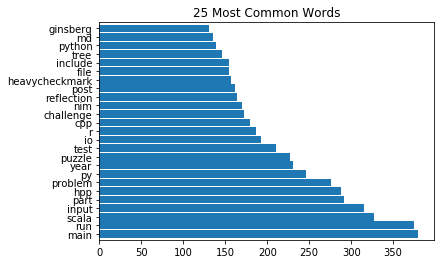

In [23]:
raw_count.sort_values(ascending=False)[0:25].plot.barh(width=.9)
plt.title('25 Most Common Words')

### How does this look for popular languages?

#### Python

In [24]:
python_text = " ".join(df[df.language == "Python"].prepped)
python_words = python_text.split()

In [25]:
python_count = pd.Series(python_words).value_counts()
python_count.head(15)

py                161
python             56
part               47
run                38
hand               35
puzzle             33
model              33
image              30
tensorflow         29
input              29
training           28
p                  28
heavycheckmark     26
use                23
repo               23
dtype: int64

Text(0.5, 1.0, 'Python 10 Most Common Words')

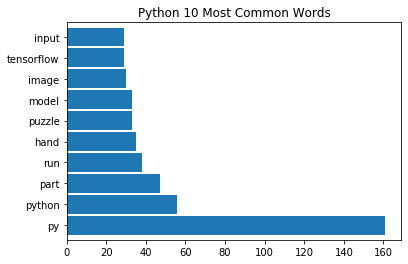

In [26]:
python_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Python 10 Most Common Words')

#### Haskell

In [27]:
haskell_text = " ".join(df[df.language == "Haskell"].prepped)
haskell_words = haskell_text.split()

In [28]:
haskell_count = pd.Series(haskell_words).value_counts()
haskell_count.head(15)

reflection         164
db                  96
dr                  91
challenge           89
h                   66
dh                  64
dg                  64
benchmark           52
dc                  50
mdday               49
mddaybenchmarks     48
haskell             47
b                   44
test                43
run                 38
dtype: int64

Text(0.5, 1.0, 'Haskell 10 Most Common Words')

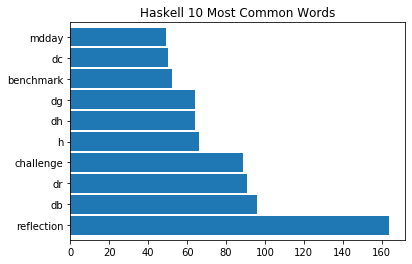

In [29]:
haskell_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Haskell 10 Most Common Words')

#### JavaScript

In [30]:
javascript_text = " ".join(df[df.language == "JavaScript"].prepped)
javascript_words = javascript_text.split()

In [31]:
javascript_count = pd.Series(javascript_words).value_counts()
javascript_count.head(15)

run                64
j                  59
star               49
puzzle             48
part               40
npm                40
index              38
test               36
year               34
input              33
simulation         27
net                26
post               26
adventofcodeday    25
node               25
dtype: int64

Text(0.5, 1.0, 'JavaScript 10 most common words')

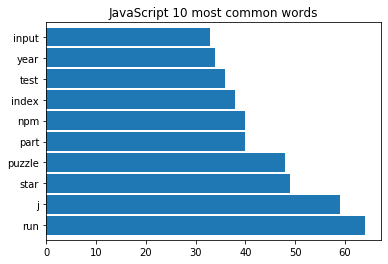

In [32]:
javascript_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('JavaScript 10 most common words')

#### Rust

In [33]:
rust_text = " ".join(df[df.language == "Rust"].prepped)
rust_words = rust_text.split()

In [34]:
rust_count = pd.Series(rust_words).value_counts()
rust_count.head(15)

r               103
target           56
reddit           50
cargo            47
input            43
rust             39
run              38
twitter          30
www              29
b                29
comment          28
daysolutions     25
main             22
part             21
x                20
dtype: int64

Text(0.5, 1.0, 'Rust 10 Most Common Words')

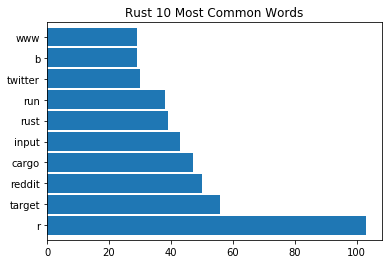

In [35]:
rust_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Rust 10 Most Common Words')

#### Clojure

In [36]:
clojure_text = " ".join(df[df.language == "Clojure"].prepped)
clojure_words = clojure_text.split()

In [37]:
clojure_count = pd.Series(clojure_words).value_counts()
clojure_count.head(15)

clj         66
clojure     41
test        20
run         18
input       13
script      13
part        11
one          9
tree         8
py           8
year         7
circleci     7
python       7
problem      7
license      7
dtype: int64

Text(0.5, 1.0, 'Clojure 10 most common words')

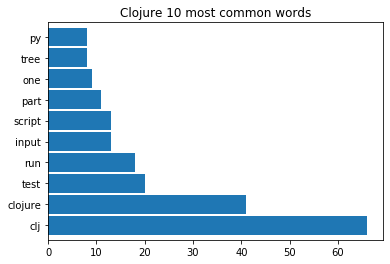

In [38]:
clojure_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Clojure 10 most common words')

#### Java

In [39]:
java_text = " ".join(df[df.language == "Java"].prepped)
java_words = java_text.split()

In [40]:
java_count = pd.Series(java_words).value_counts()
java_count.head(15)

java         45
problem      33
tree         26
statement    25
run          23
input        21
main         16
language     14
sbaars       11
io           11
shield       11
img          11
part         10
badge         9
completed     8
dtype: int64

Text(0.5, 1.0, 'Java 10 most common words')

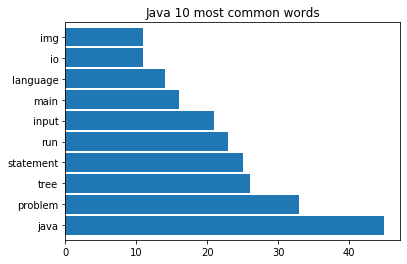

In [41]:
java_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Java 10 most common words')

### Does the length of the README vary by programming language?

### Do different programming languages use a different number of unique words?

# Model

Here we will look at the raw count, term frequency (tf), and inverse document frequency (idf). Then we will use that information to create models. We will train several different models and pick the best one. We will test the best model and evaluate the results. 

In [42]:
# Create a data frame with raw count and tf
tf_df = pd.DataFrame({'raw_count': raw_count})
tf_df = tf_df.assign(term_frequency = lambda df: df.raw_count / df.raw_count.sum())
tf_df.raw_count.max()
tf_df.head()

,raw_count,term_frequency
main,380,0.012543
run,375,0.012378
scala,327,0.010794
input,315,0.010397
part,292,0.009638


In [43]:
# Create a function that takes in a word and returns the idf of that word
def idf(word):
    n_occurrences = sum([1 for doc in df.prepped if word in doc])
    n_docs = len(df.prepped)
    idf = np.log(n_docs/n_occurrences)
    return idf

In [44]:
# Create a list of unique words
unique_words = pd.Series(' '.join(df.prepped).split()).unique()
len(unique_words)

4447

In [45]:
idf_df = pd.DataFrame(dict(word = unique_words))
idf_df = idf_df.assign(idf = lambda df: df.word.apply(idf))
idf_df = idf_df.set_index('word').sort_values(by='idf', ascending = False)
idf_df.head(25)

,idf
word,
coqsimpleio,5.620401
feeddict,5.620401
imagenpexpanded,5.620401
drawboxonimage,5.620401
detectmultithreaded,5.620401
threaded,5.620401
camera,5.620401
videe,5.620401
detectsinglethreaded,5.620401


In [46]:
df.language.value_counts()

Python              39
JavaScript          35
Haskell             25
Rust                19
Clojure             15
Go                  14
Java                12
Kotlin              12
Ruby                10
C#                  10
Elixir               9
C++                  8
Scala                8
R                    7
OCaml                5
TypeScript           4
PHP                  3
Jupyter Notebook     3
C                    3
HTML                 2
Elm                  2
Perl                 2
F#                   2
Scheme               2
Pony                 2
Crystal              2
Swift                2
Julia                2
Dart                 1
APL                  1
Shell                1
Coq                  1
Mathematica          1
Reason               1
PureScript           1
Erlang               1
TSQL                 1
Racket               1
Nim                  1
Ada                  1
Haxe                 1
PowerShell           1
Smalltalk            1
Eiffel     

#### It will not be realistic or benefitial to train and predict languages with a very small sample size. To accomodate for this, we create the label 'Other'. Other includes all languages that have less than 9 samples. This leaves us with the top 11 languages and the label Other for a total of 12 programming languages. 

In [47]:
df['language'] = df['language'].replace({'C++':'Other', 'Scala':'Other', 'OCaml':'Other','C':'Other', 'Elm':'Other', 'Pony':'Other', 'HTML':'Other', 'Perl':'Other','APL':'Other', 'Haxe':'Other', 'Racket':'Other', 'PureScript':'Other', 'Coq':'Other','F#':'Other', 'PHP':'Other', 'TSQL':'Other', 'Crystal':'Other', 'Nim':'Other', 'Shell':'Other', 'Eiffel':'Other', 'Mathematica':'Other', 'Swift':'Other', 'Reason':'Other', 'TypeScript':'Other', 'Jupyter Notebook':'Python', 'Scheme':'Other', 'Powershell':'Other', 'Julia':'Other', 'PowerShell':'Other', 'Ada':'Other', 'Erlang':'Other', 'Smalltalk':'Other', 'D':'Other', 'Dart':'Other', 'R':'Other'})

In [48]:
df.language.value_counts()

Other         73
Python        42
JavaScript    35
Haskell       25
Rust          19
Clojure       15
Go            14
Java          12
Kotlin        12
Ruby          10
C#            10
Elixir         9
Name: language, dtype: int64

In [49]:
sum(df.language.value_counts())

276

## Split

In [50]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.prepped)
y = df.language

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

## Baseline: Predict Most Popular Language

#### Baseline Accuracy: 26%

Our data consists of 276 readme entries. Our most popular programming language is 'Other' with 73. If we were to guess Other for every language, we would be correct 26% of the time. Our final model must beat this baseline accuracy of 26%.

## Model 1: Logistic Regression

In [51]:
lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

### Train Evaluation

In [52]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 67.27%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
Clojure      0        5       0   0        0     0           0       0      0   
Elixir       0        0       1   0        0     0           0       0      0   
Go           0        0       0   3        0     0           0       0      0   
Haskell      0        0       0   0       12     0           0       0      0   
Java         0        0       0   0        0     3           0       0      0   
JavaScript   0        0       0   1        0     0          22       0      0   
Kotlin       0        0       0   0        0     0           0       4      0   
Other        8        7       6   6        7     6           6       5     57   
Python       0        0       0   1        1     1           0       1      1   
Ruby         0        0       0   0        0     0           0       0 

## Model 2: Decision Tree

In [53]:
# Create
tree = DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=123)
# Fit
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [54]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = tree.predict(X_train)
test['predicted'] = tree.predict(X_test)

### Train Evaluation

In [55]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 67.27%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
C#           1        0       0   0        0     0           0       0      0   
Clojure      0       10       0   0        0     0           0       0      0   
Elixir       0        0       7   0        0     0           0       0      0   
Go           0        0       0   8        0     0           5       0      3   
Haskell      0        0       0   0       11     0           0       0      0   
Java         0        0       0   0        0     9           0       0      0   
JavaScript   0        0       0   0        0     0           1       0      0   
Kotlin       0        0       0   0        0     0           0       8      0   
Other        7        2       0   3        9     1          22       2     55   
Python       0        0       0   0        0     0           0       0 

## Model 3: Random Forest

In [56]:
# Create
rf = RandomForestClassifier(min_samples_leaf=3, max_depth=9, random_state=123)
# Fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [57]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = rf.predict(X_train)
test['predicted'] = rf.predict(X_test)

### Train Evaluation

In [58]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 55.00%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
Clojure      0        5       0   0        0     0           0       0      0   
Go           0        0       1   4        0     0           0       0      0   
Haskell      0        0       0   0        6     0           0       0      0   
Java         0        0       0   0        0     3           0       0      0   
JavaScript   1        0       0   2        0     0          19       0      1   
Kotlin       0        0       0   0        0     0           0       5      0   
Other        7        7       4   5       13     6           9       5     56   
Python       0        0       1   0        0     1           0       0      1   
Ruby         0        0       0   0        0     0           0       0      0   
Rust         0        0       1   0        1     0           0       0 

## Model 4: K-Nearest Neighbors

In [59]:
# Create
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform')
# Fit
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [60]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = knn.predict(X_train)
test['predicted'] = knn.predict(X_test)

### Train Evaluation

In [61]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 66.36%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
C#           2        0       0   0        0     0           0       0      3   
Clojure      0       11       0   0        0     0           0       0      0   
Elixir       0        0       6   0        0     0           0       0      0   
Go           0        0       0   7        0     1           2       1      2   
Haskell      1        1       0   1       13     0           0       0      0   
Java         1        0       0   0        0     6           1       1      2   
JavaScript   1        0       0   2        1     1          21       2      5   
Kotlin       0        0       0   0        0     0           1       5      3   
Other        1        0       0   0        2     1           2       1     36   
Python       2        0       1   1        2     1           1       0 

## Testing our Best Model

Our best perfoming model is the decision tree. Let's run our model on the test data to see how it does. 


In [62]:
# Create
tree = DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=123)
# Fit
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [63]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = tree.predict(X_train)
test['predicted'] = tree.predict(X_test)

In [64]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 51.79%
---
Confusion Matrix
actual     C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                      
Clojure     0        2       0   0        0     0           0       0      0   
Elixir      0        0       2   0        0     0           0       0      0   
Go          1        0       0   1        0     0           1       0      0   
Haskell     0        0       0   0        2     0           0       0      0   
Java        0        0       0   0        0     1           0       0      1   
Other       1        1       0   2        3     0           6       2     13   
Python      0        0       0   0        0     0           0       0      0   
Ruby        0        0       0   0        0     1           0       0      0   
Rust        0        0       0   0        0     0           0       0      1   

actual     Python  Ruby  Rust  
predicted                      
Clojure         0

#### Conclusion: Our best model is the decision tree. When given unseen test data, our model returns an accuracy of about 52%. This is significant, given our model is making its predictions from 12 options. It also vastly outperforms our baseline model, which had an accuracy of 26%.

### Build a function that will take in the text of a README file, and tries to predict the programming language.